# Imports

In [2]:
%load_ext autoreload
%autoreload 2
import mc.pocket as pocket
%aimport mc.pocket
from util import *
%aimport mc.util 
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import scipy

# T=0

## Monomers

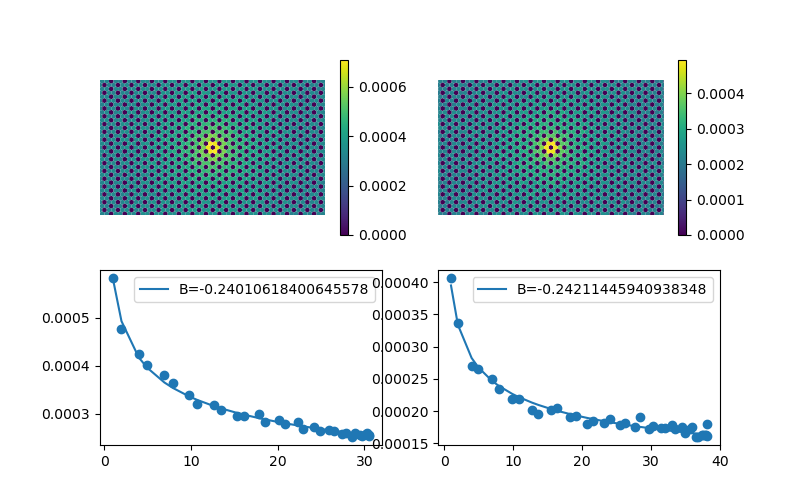

In [52]:
# data1 = read_accumulator("data/t0j0/doped/-1/96x96_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=10)[0].reshape((96, 96))
# data2 = read_accumulator("data/t0j0/doped/-1/120x120_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=10)[0].reshape((120, 120))

# data1 = read_accumulator("data/t0j0/doped2/-1/96x96_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=0)[0].reshape((96, 96))
# data2 = read_accumulator("data/t0j0/doped2/-1/120x120_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=0)[0].reshape((120, 120))

data1 = read_accumulator("data/t0j0/doped/-1/96x96_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=10)[0].reshape((96, 96))
data2 = read_accumulator("data/t0j0/doped/-1/120x120_r-3_t0.000000_j0.000_50000000.20_0/mono-mono.dat", skip=0)[0].reshape((120, 120))

fig, ax = plt.subplots(2, 2, figsize=[8, 5])
plot2d(ax[0, 0], data1)
plot2d(ax[0, 1], data2)

def mod(data, x, y):
    return data.T[x%(data.shape[0]), y%(data.shape[1])]

def symmetrize(data):
    lin = [0]
    xs = np.arange(data.shape[0]//2)
    for i in range(1, data.shape[0]//2):
        total = 0
        total += mod(data, 0, i)
        total += mod(data, i, 0)
        total += mod(data, -i, i)
        total += mod(data, -i, 0)
        total += mod(data, -i, -i)
        total += mod(data, i, -i)
        lin.append(total / 6)
    lin = np.array(lin)

    L = data.shape[0]
    xs = np.sin(np.pi/L * xs) / (np.pi/L)

    indices = np.arange(len(xs))
    return xs[indices % 3 != 0], lin[indices % 3 != 0]

def fit(xs, ys):
    import scipy

    def fun(x, A, B):
        return B * np.power(np.abs(x), A)
    param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-0.25, 0.002])

    # def fun(x, A, B, C):
    #     return B * np.power(np.abs(x), A) + C
    # param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-0.25, 0.002, 0])

    # def fun(x, A, B, C):
    #     return B * np.exp(A * x) + C
    # param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-0.13, 0.002, 0])

    return fun, param

x1, y1 = symmetrize(data1)
fun, param = fit(x1[:], y1[:])
ax[1, 0].scatter(x1, y1)
ax[1, 0].plot(x1, fun(x1, *param), label=f"B={param[0]}")
# ax[1, 0].set_yscale("log")
# ax[1, 0].set_xscale("log")
ax[1, 0].legend()

x2, y2 = symmetrize(data2)
fun, param = fit(x2[:], y2[:])
ax[1, 1].scatter(x2, y2)
ax[1, 1].plot(x2, fun(x2, *param), label=f"B={param[0]}")
# ax[1, 1].set_yscale("log")
# ax[1, 1].set_xscale("log")
ax[1, 1].legend()

### CFT scaling collapse

In [43]:
L, data = get_all_data("data/t0j0/doped/-1/*50000000.20_0/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=1, by="l")

Text(0.5, 0, '$\\overline{x}/L$')

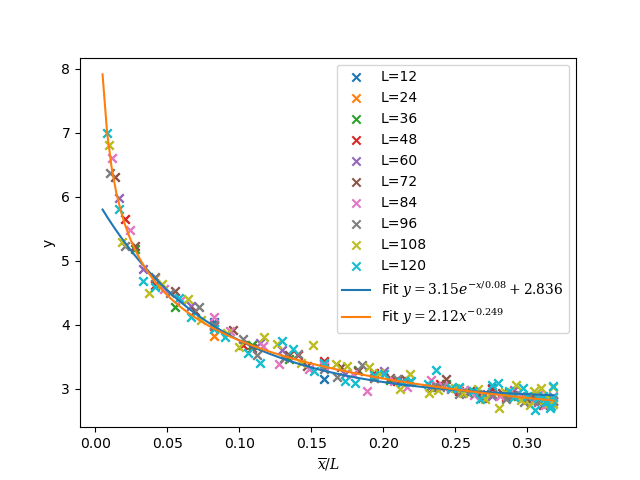

In [44]:
plt.close("all")
plt.figure()
xs = []
ys = []
for l, d in zip(L, data):
    x = np.arange(l)
    scaledx = np.sin(np.pi * x/l) / (np.pi/l)
    scaledx = scaledx/l

    d = d * l**2

    plt.scatter(scaledx[x%3!=0], d[x%3!=0, 0], marker="x", label="L="+str(l))
    for i in range(d.shape[0]//2):
        if i % 3 == 0: continue
        xs.append(scaledx[i])
        ys.append(d[i, 0])

x = np.linspace(0.005, 1/np.pi, 100)

def fun(x, A, B, C):
    return B * np.exp(np.abs(x) / A) + C
param, _ = scipy.optimize.curve_fit(fun, xs[:20], ys[:20], p0=[-0.25, 1, 1/16], bounds=([-5, 0, 0], [-0.01, np.inf, 100]))
plt.plot(x, fun(x, *param), label=f"Fit $y={param[1]:.2f}e^{{-x/{-param[0]:.2f}}}+{param[2]:.3f}$")

def fun(x, A, B):
    return B * np.power(np.abs(x), A)
param, _ = scipy.optimize.curve_fit(fun, xs[:20], ys[:20], p0=[-0.25, 1], bounds=([-5, 0], [-0.01, np.inf]))
plt.plot(x, fun(x, *param), label=f"Fit $y={param[1]:.2f}x^{{{param[0]:.3f}}}$")

plt.legend()
plt.ylabel("y")
plt.xlabel("$\\overline{x}/L$")

## Trimers

### Scaling

In [6]:
L, data, N = get_all_data("data/t0j0/doped/-1/*20_0/tri-tri.dat", lambda data, props: data[0].reshape((props["l"], props["l"], 2)), skip=3, by="l", with_counts=True)
# L, data = get_all_data("data/t0j0/doped/1.48/*_0/tri-tri.dat", lambda data, props: data[0].reshape((props["l"], props["l"], 2)), skip=30, by="l")
# L, data = get_all_data("data/t0j0/full/*_0/tri-tri.dat", lambda data, props: data[0].reshape((props["l"], props["l"], 2)), skip=50, by="l")

Text(0, 0.5, 'Trimer correlation at L/2')

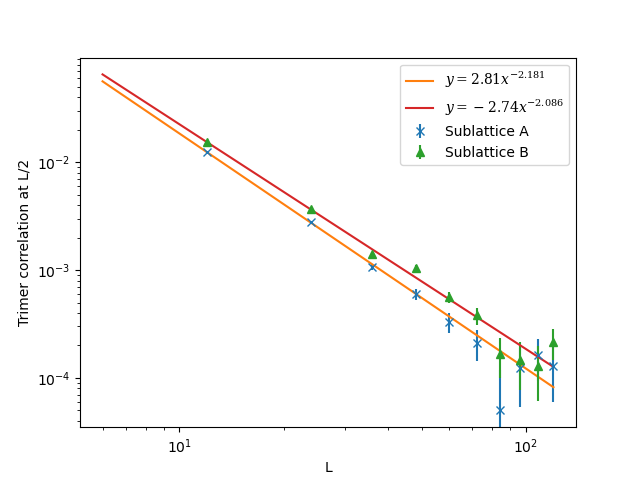

In [16]:
def fit(xs, ys):
    import scipy

    # def fun(x, A, B, C):
    #     return B * np.power(np.abs(x), A) + C
    # param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-2, 1, 0])
    def fun(x, A, B):
        return B * np.power(np.abs(x), A)
    param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-2, 1])

    return fun, param

values = []
values2 = []
for l, d in zip(L, data):
    values.append(d[l//2,0,0])
    values2.append(d[l//2,0,1])

values = np.array(values) - 1/6
values2 = -(np.array(values2) - 1/6)

plt.figure()
plt.errorbar(L, values, yerr=np.sqrt((values + 1/6)*(1-values-1/6))/np.sqrt(N*12), ls="", marker="x", label="Sublattice A")
fun, param = fit(L, values)
xs = np.linspace(6, 120, 30)
plt.plot(xs, fun(xs, *param), label=f"$y={param[1]:.2f}x^{{{param[0]:.3f}}}$")

plt.errorbar(L, values2, yerr=np.sqrt((values2 + 1/6)*(1-values2-1/6))/np.sqrt(N*12), ls="", marker="^", label="Sublattice B")
fun, param = fit(L, values2)
xs = np.linspace(6, 120, 30)
plt.plot(xs, fun(xs, *param), label=f"$y=-{param[1]:.2f}x^{{{param[0]:.3f}}}$")

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("L")
plt.ylabel("Trimer correlation at L/2")

## Entropy per trimer

/tmp/ipykernel_721861/3383800291.py:21: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  entropies.append(scipy.integrate.quad(fun, 0.06, 50, limit=200)[0])


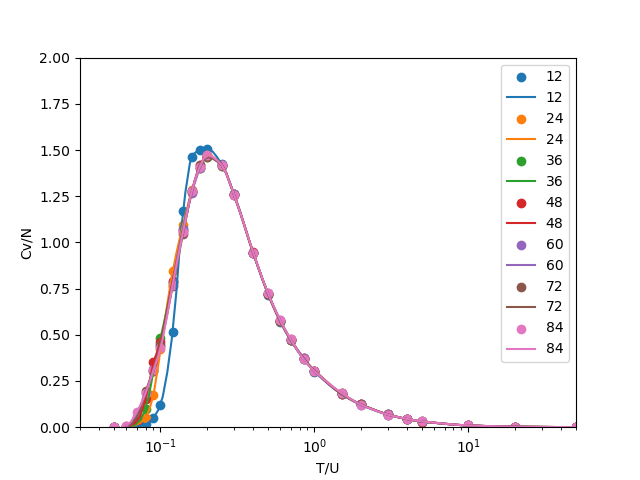

In [11]:
plt.close("all")
plt.figure()
plt.ylabel("Cv/N")
plt.xscale("log")
plt.xlabel("T/U")
plt.xlim([0.03, 50])
plt.ylim([0, 2])

skip = 300000
ls = []
entropies = []
for L in [12, 24, 36, 48, 60, 72, 84]:
    ts1, ds1 = get_all_cvs(f"new-data/vsweeps/0/{L}x{L}_r-0_t*_j0.000_20000000.20_0/energy.dat", skip=skip)
    ts2 = np.geomspace(0.06, 50, 100)

    interp = lambda x: np.piecewise(x, [x<0.06, (0.06<=x)*(x<50), 50<=x], [0, scipy.interpolate.PchipInterpolator(ts1, ds1), 0])

    fun = lambda x: interp(x) / x

    ls.append(L)
    entropies.append(scipy.integrate.quad(fun, 0.06, 50, limit=200)[0])

    plt.scatter(ts1, ds1, label=L)
    plt.plot(ts2, interp(ts2), label=L)

ls = np.array(ls)
entropies = np.array(entropies)
plt.legend()

[0.25216424 0.63636567]


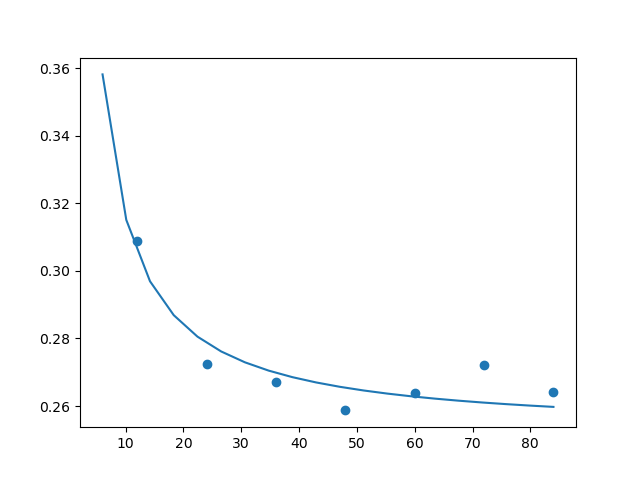

In [12]:
def S(n):
    return 6 * np.log(6) - 5 * np.log(5) - 1/2/n * np.log(5*np.pi*n/3)

plt.figure()
plt.scatter(ls, S(ls**2/3)-entropies)

def fun(x, A, B):
    return A + B/x
param, _ = scipy.optimize.curve_fit(fun, ls[:-1], S(ls[:-1]**2/3)-entropies[:-1])

xs =np.linspace(6, 84, 20)
plt.plot(xs, fun(xs, *param))
print(param)

# T>0

## Phase diagram

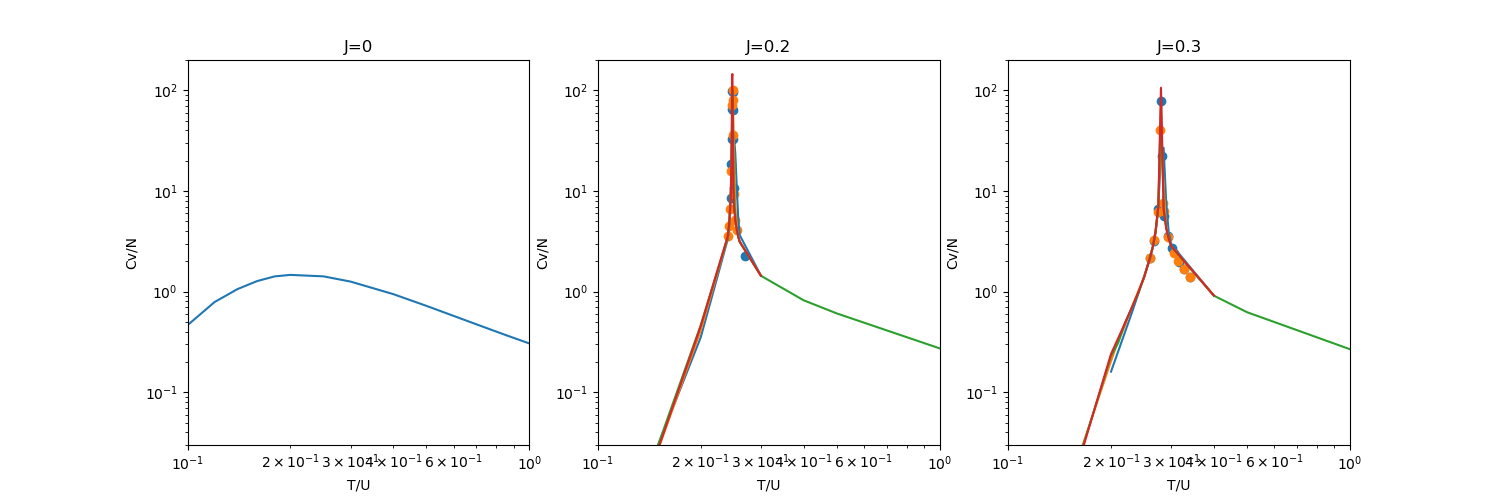

In [89]:
skip = 2000
fig, ax = plt.subplots(1, 3, figsize=[15,5])

ts0, ds0 = get_all_cvs("new-data/vsweeps/0/48*/energy.dat", skip=skip)
ax[0].plot(ts0, ds0)
ax[0].set_title("J=0")

ts1, ds1 = get_all_cvs("new-data/vsweeps/0.2/24*/energy.dat", skip=skip)
ax[1].plot(ts1, ds1)
ts1, ds1 = get_all_cvs("new-data/vsweeps/0.2/36*/energy.dat", skip=skip)
ax[1].plot(ts1, ds1)
ts1, ds1 = get_all_cvs("new-data/vsweeps/0.2/48*/energy.dat", skip=skip)
ax[1].plot(ts1, ds1)
ts1, ds1 = get_all_cvs("new-data/vsweeps/0.2/60*/energy.dat", skip=skip)
ax[1].plot(ts1, ds1)

ts0, ds0 = get_all_cvs("new-data/pt/0.2/48/0/*/energy.dat", skip=skip)
ax[1].scatter(ts0, ds0)
ts0, ds0 = get_all_cvs("new-data/pt/0.2/48/1/*/energy.dat", skip=skip)
ax[1].scatter(ts0, ds0)
ax[1].set_title("J=0.2")

ts1, ds1 = get_all_cvs("new-data/vsweeps/0.3/24*/energy.dat", skip=skip)
ax[2].plot(ts1, ds1)
ts1, ds1 = get_all_cvs("new-data/vsweeps/0.3/36*/energy.dat", skip=skip)
ax[2].plot(ts1, ds1)
ts1, ds1 = get_all_cvs("new-data/vsweeps/0.3/48*/energy.dat", skip=skip)
ax[2].plot(ts1, ds1)
ts1, ds1 = get_all_cvs("new-data/vsweeps/0.3/60*/energy.dat", skip=skip)
ax[2].plot(ts1, ds1)

ts0, ds0 = get_all_cvs("new-data/pt/0.3/0/*/energy.dat", skip=skip)
ax[2].scatter(ts0, ds0)
ts0, ds0 = get_all_cvs("new-data/pt/0.3/1/*/energy.dat", skip=skip)
ax[2].scatter(ts0, ds0)
ax[2].set_title("J=0.3")


for a in ax.flatten():
    a.set_ylabel("Cv/N")
    a.set_xlabel("T/U")
    a.set_xscale("log")
    a.set_yscale("log")
    a.set_xlim([0.10, 1])
    a.set_ylim([0.03, 200])

### rt3 transitions

ValueError: new-data/pt/0.2/36/0/36x36_r-0_t0.240000_j0.200_10000000.15_0/energy.dat

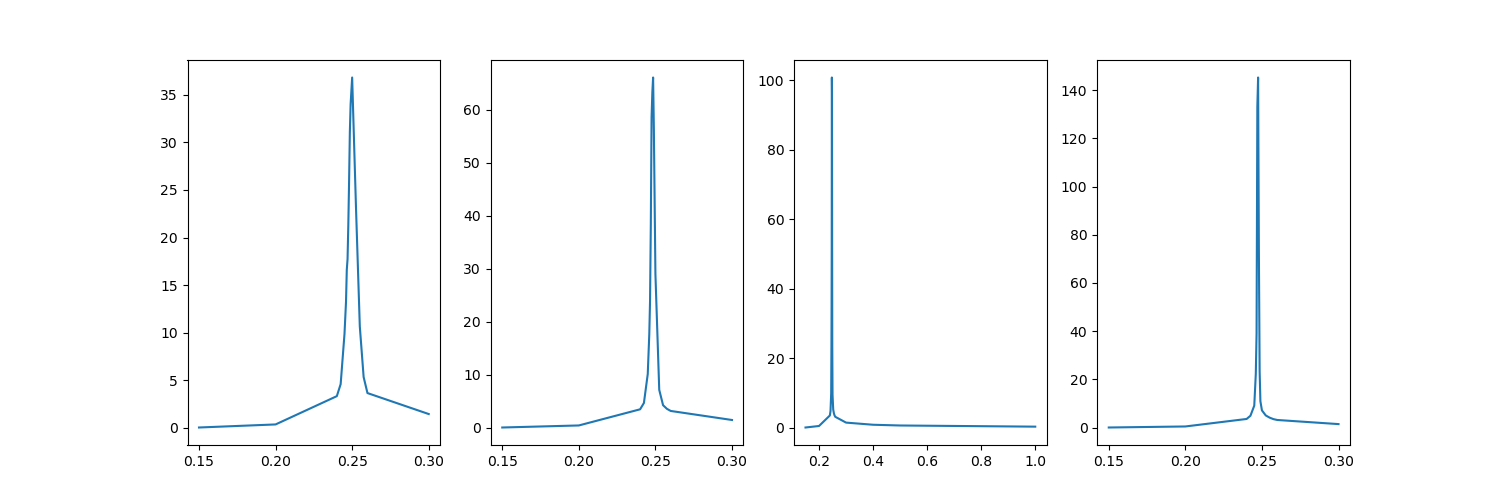

In [116]:
skip=0
fig, ax = plt.subplots(1, 4, figsize=[15,5])

ts1, ds1 = get_all_cvs("new-data/vsweeps/0.2/24*/energy.dat", skip=skip)
ax[0].plot(ts1, ds1)
ts1, ds1 = get_all_cvs("new-data/vsweeps/0.2/36*/energy.dat", skip=skip)
ax[1].plot(ts1, ds1)
ts1, ds1 = get_all_cvs("new-data/vsweeps/0.2/48*/energy.dat", skip=skip)
ax[2].plot(ts1, ds1)
ts1, ds1 = get_all_cvs("new-data/vsweeps/0.2/60*/energy.dat", skip=skip)
ax[3].plot(ts1, ds1)

ts0, ds0 = get_all_cvs("new-data/pt/0.2/36/0/*/energy.dat", skip=skip)
ax[1].scatter(ts0, ds0)
ts0, ds0 = get_all_cvs("new-data/pt/0.2/48/0/*/energy.dat", skip=skip)
ax[2].scatter(ts0, ds0)
ts0, ds0 = get_all_cvs("new-data/pt/0.2/48/1/*/energy.dat", skip=skip)
ax[2].scatter(ts0, ds0)

for a in ax:
    a.set_yscale('log')
    a.set_xscale('log')
    a.set_ylim([1, 200])
    a.set_xlim([0.23, 0.27])

### BW transitions

In [ ]:

ts2, ds2 = get_all_cvs("new-data/roughsweeps/-1/48*/energy.dat", skip=skip)
ax[1,0].plot(ts2, ds2, label="48x48 J=-1")
ts0, ds0 = get_all_cvs("new-data/rough-pt/-1/0/*/energy.dat", skip=skip)
ax[1,0].scatter(ts0, ds0, label="48x48 Peak")
ts0, ds0 = get_all_cvs("new-data/rough-pt/-1/1/*/energy.dat", skip=skip)
ax[1,0].scatter(ts0, ds0, label="48x48 Peak")
ts0, ds0 = get_all_cvs("new-data/rough-pt/-1/2/*/energy.dat", skip=skip)
ax[1,0].scatter(ts0, ds0, label="48x48 Peak")
ts0, ds0 = get_all_cvs("new-data/rough-pt/-1/3/*/energy.dat", skip=skip)
ax[1,0].scatter(ts0, ds0, label="48x48 Peak")
ax[1,0].set_title("J=-1")

ts2, ds2 = get_all_cvs("new-data/roughsweeps/-1.5/48*/energy.dat", skip=skip)
ax[1,1].plot(ts2, ds2, label="48x48 J=-1.5")
ts0, ds0 = get_all_cvs("new-data/rough-pt/-1.5/0/*/energy.dat", skip=skip)
ax[1,1].scatter(ts0, ds0, label="48x48 Peak")
ts0, ds0 = get_all_cvs("new-data/rough-pt/-1.5/1/*/energy.dat", skip=skip)
ax[1,1].scatter(ts0, ds0, label="48x48 Peak")
ts0, ds0 = get_all_cvs("new-data/rough-pt/-1.5/2/*/energy.dat", skip=skip)
ax[1,1].scatter(ts0, ds0, label="48x48 Peak")
ts0, ds0 = get_all_cvs("new-data/rough-pt/-1.5/3/*/energy.dat", skip=skip)
ax[1,1].scatter(ts0, ds0, label="48x48 Peak")
ax[1,1].set_title("J=-1.5")

ts2, ds2 = get_all_cvs("new-data/roughsweeps/-2/48*/energy.dat", skip=skip)
ax[1,2].plot(ts2, ds2, label="48x48 J=2")
ts0, ds0 = get_all_cvs("new-data/rough-pt/-2/0/*/energy.dat", skip=skip)
ax[1,2].scatter(ts0, ds0, label="48x48 Peak")
ts0, ds0 = get_all_cvs("new-data/rough-pt/-2/1/*/energy.dat", skip=skip)
ax[1,2].scatter(ts0, ds0, label="48x48 Peak")
ax[1,2].set_title("J=-2")

Text(0.5, 1.0, 'J=-1.5')

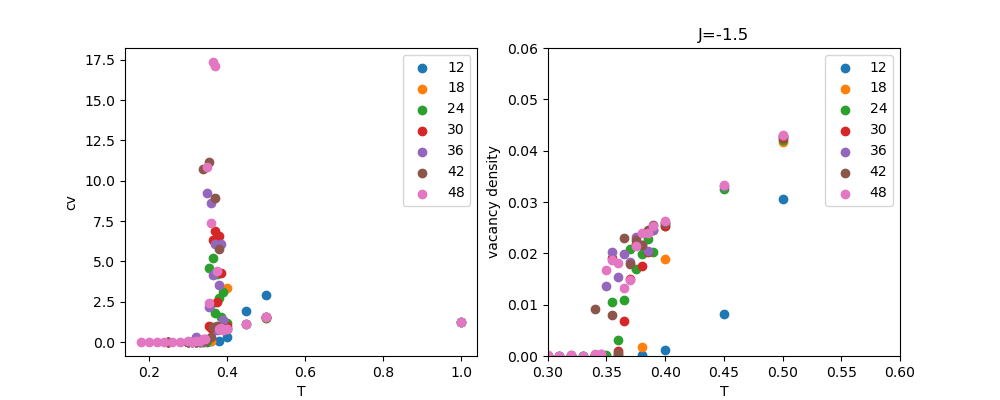

In [186]:
fig, ax = plt.subplots(1, 2, figsize=[10, 4])
for l in [12, 18, 24, 30, 36, 42, 48]:
    ts, ds = get_all_cvs(f"new-data/roughsweeps/-1.5/{l}*/energy.dat", skip=5000)
    ax[0].scatter(ts, ds, label=l)
    ts, ds = get_all_data(f"new-data/roughsweeps/-1.5/{l}*/cluster-count.dat", lambda x, props: x[0][0], skip=5000)
    ax[1].scatter(ts, ds/(l**2), label=l)


ax[0].legend()
ax[0].set_xlabel("T")
ax[0].set_ylabel("cv")
ax[1].legend()
ax[1].set_xlabel("T")
ax[1].set_ylabel("vacancy density")
ax[1].set_xlim([0.3,0.6])
ax[1].set_ylim([0,0.06])
plt.title("J=-1.5")

## Trimer structure factor

Text(0.5, 1.0, 'J=-0.1 T=0.05 48x48')

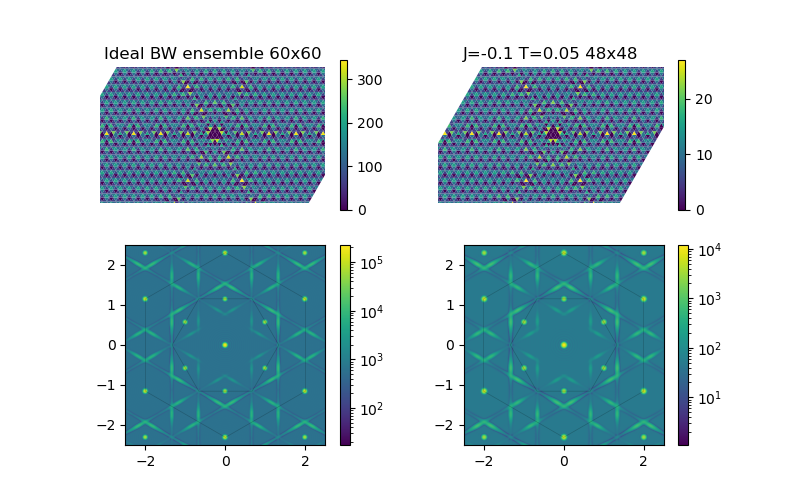

In [74]:
data1 = read_accumulator("data/idealbw/60x60_r-3_uinf_4j0.00_1000.1_0/tri-tri.dat")[0].reshape((60, 60, 2))
data2 = read_accumulator("data/vsweeps/-0.1/48x48_r-0_t0.0200_j-0.1000_40000000.5_0/tri-tri.dat")[0].reshape((48, 48, 2))
fig, ax = plt.subplots(2, 2, figsize=[8, 5], height_ratios=[6, 8])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot_FT(ax[1,0], FT_hex(data1), proj="logabs")
plot_FT(ax[1,1], FT_hex(data2), proj="logabs")
ax[0,0].set_title("Ideal BW ensemble 60x60")
ax[0,1].set_title("J=-0.1 T=0.05 48x48")

Text(0.5, 1.0, 'J=0.1 T=0.09 48x48')

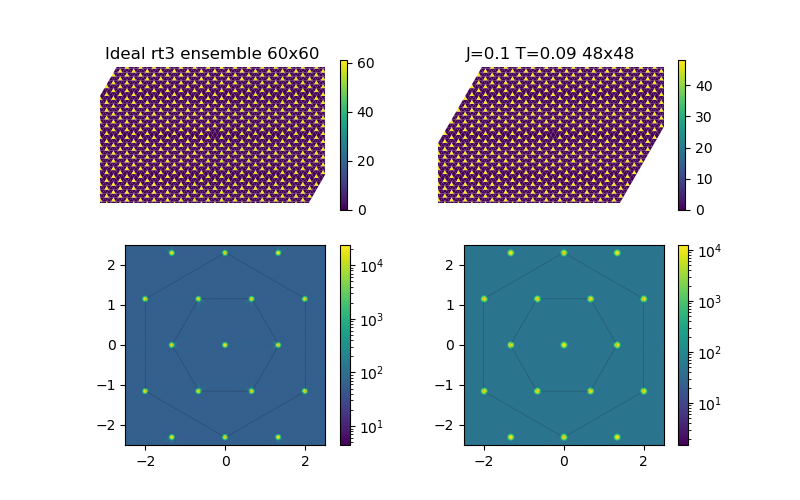

In [145]:
data1 = read_accumulator("data/idealrt3/60x60_r-0_t0.000000_j0.000_1000.1_0/tri-tri.dat")[0].reshape((60, 60, 2))
data2 = read_accumulator("data/vsweeps/0.1/48x48_r-0_t0.0900_j0.1000_40000000.5_0/tri-tri.dat")[0].reshape((48, 48, 2))
fig, ax = plt.subplots(2, 2, figsize=[8, 5], height_ratios=[6, 8])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot_FT(ax[1,0], FT_hex(data1), proj="logabs")
plot_FT(ax[1,1], FT_hex(data2), proj="logabs")
ax[0,0].set_title("Ideal rt3 ensemble 60x60")
ax[0,1].set_title("J=0.1 T=0.09 48x48")

Text(0.5, 1.0, 'T=0.5 J=0 48x48')

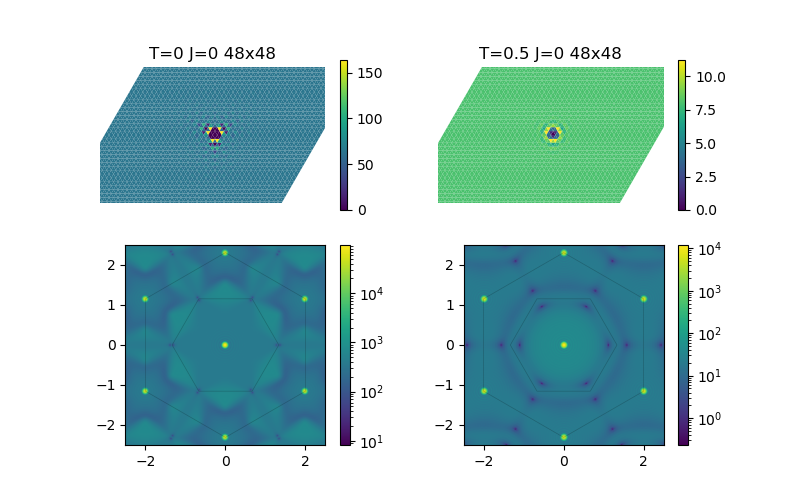

In [77]:
data1 = read_accumulator("data/rt3trans/48x48_r-3_uinf_4j0.00_20000000.5_0/tri-tri.dat")[0].reshape((48, 48, 2))
data2 = read_accumulator("data/vsweeps/0.01/48x48_r-0_t0.5000_j0.0100_40000000.5_0/tri-tri.dat")[0].reshape((48, 48, 2))
fig, ax = plt.subplots(2, 2, figsize=[8, 5], height_ratios=[6, 8])
plot2d_hex(ax[0,0], data1)
plot2d_hex(ax[0,1], data2)
plot_FT(ax[1,0], FT_hex(data1), proj="logabs")
plot_FT(ax[1,1], FT_hex(data2), proj="logabs")
ax[0,0].set_title("T=0 J=0 48x48")
ax[0,1].set_title("T=0.5 J=0 48x48")

## Restricted mobility and confinement

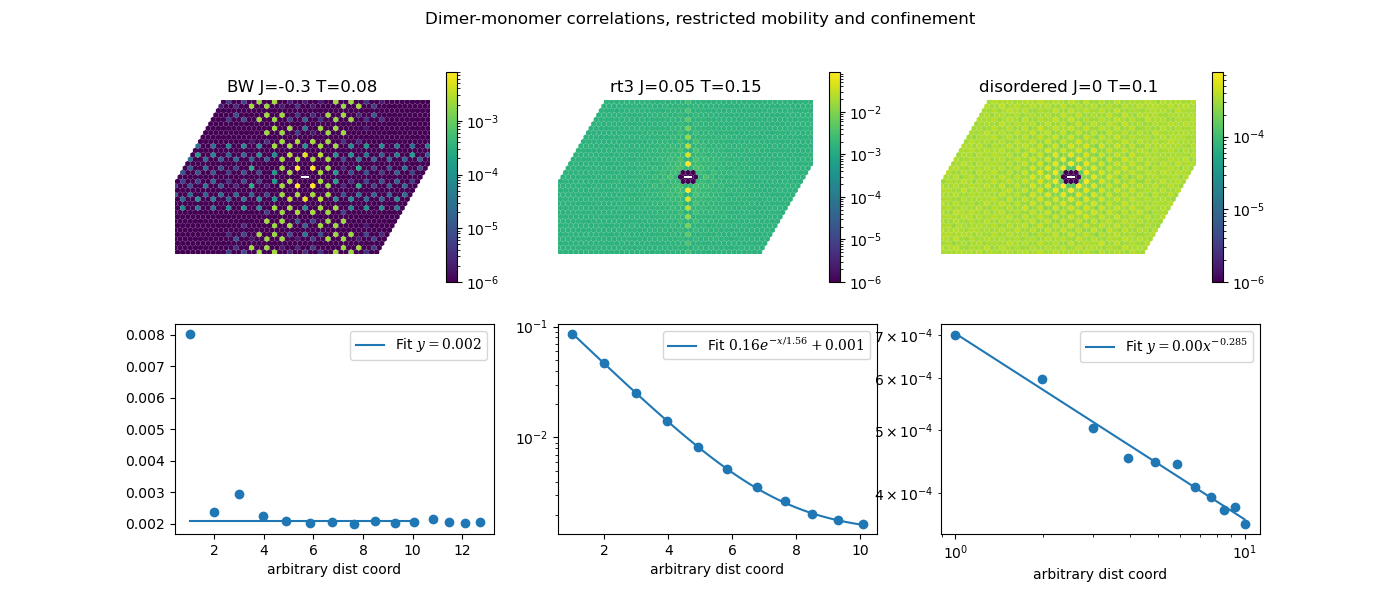

In [54]:
fig, ax = plt.subplots(2, 3, figsize=[14, 6])

fig.suptitle("Dimer-monomer correlations, restricted mobility and confinement")

data1 = read_accumulator("new-data/finite-t/j-0.3t0.08/48x48_r-3_t0.080000_j-0.300_20000000.20_0/mono-di.dat")[0].reshape((48, 48), order='F')
plot2d(ax[0,0], data1, log=True, show_dimer=True)
ax[0,0].set_title("BW J=-0.3 T=0.08")

data2 = read_accumulator("new-data/finite-t/j0.05t0.15/48x48_r-3_t0.150000_j0.050_20000000.20_0/mono-di.dat")[0].reshape((48, 48), order='F')
plot2d(ax[0,1], data2, log=True, show_dimer=True)
ax[0,1].set_title("rt3 J=0.05 T=0.15")

data3 = read_accumulator("new-data/finite-t/j0t0.1/48x48_r-3_t0.100000_j0.000_20000000.20_0/mono-di.dat")[0].reshape((48, 48), order='F')
plot2d(ax[0,2], data3, log=True, show_dimer=True)
ax[0,2].set_title("disordered J=0 T=0.1")

def mod(data, x, y):
    return data[x%(data.shape[0]), y%(data.shape[1])]

def symmetrize(data, cut):
    if cut == "perp":
        xs = np.arange(data.shape[0]//4)
        ys = np.zeros_like(xs, dtype=float)
        for i in xs:
            ys[i] = np.mean([mod(data, -i, 1+2*i), mod(data, 1+i, -1-2*i)][0])
    else:
        xs = np.arange(2*(data.shape[0]//6))
        ys = np.zeros_like(xs, dtype=float)
        for i in xs:
            ii = i // 2
            if i % 2 == 0:
                ys[i] = np.mean([mod(data, 0, 1+3*ii), mod(data, -3*ii, 1+3*ii),
                                 mod(data, 1+3*ii, -1-3*ii), mod(data, 1, -1-3*ii)])
            else:
                ys[i] = np.mean([mod(data, 1, 2+3*ii), mod(data, -2-3*ii, 2+3*ii),
                                 mod(data, 3+3*ii, -2-3*ii), mod(data, 0, -2-3*ii)])
    
    xs = np.sin(np.pi * xs/data.shape[0]) / (np.pi/data.shape[0]) 
    return xs[1:], ys[1:]

x = np.linspace(1, 10, 100)

xs, ys = symmetrize(data1, "zigzag")
ax[1, 0].scatter(xs, ys)
def fun(x, A):
    return np.ones_like(x) * A

param, _ = scipy.optimize.curve_fit(fun, xs[3:], ys[3:])
ax[1, 0].plot(x, fun(x, *param), label=f"Fit $y={param[0]:.3f}$")
ax[1, 0].set_xlabel("arbitrary dist coord")
ax[1, 0].legend()

xs, ys = symmetrize(data2, "perp")
ax[1, 1].scatter(xs, ys)
def fun(x, A, B, C):
    return B * np.exp(np.abs(x) / A) + C
param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-0.25, 1, 0])
ax[1, 1].plot(x, fun(x, *param), label=f"Fit ${param[1]:.2f}e^{{-x/{-param[0]:.2f}}}+{param[2]:.3f}$")
ax[1, 1].set_yscale("log")
ax[1, 1].set_xlabel("arbitrary dist coord")
ax[1, 1].legend()

xs, ys = symmetrize(data3, "perp")
ax[1, 2].scatter(xs, ys)
def fun(x, A, B):
    return B * np.power(np.abs(x), A)
param, _ = scipy.optimize.curve_fit(fun, xs, ys, p0=[-0.25, 1], bounds=([-5, 0], [-0.01, np.inf]))
ax[1, 2].plot(x, fun(x, *param), label=f"Fit $y={param[1]:.2f}x^{{{param[0]:.3f}}}$")
ax[1, 2].set_yscale("log")
ax[1, 2].set_xscale("log")
ax[1, 2].set_xlabel("arbitrary dist coord")
ax[1, 2].legend()

In [205]:
L, data = get_all_data("new-data/finite-t/t0.05j0/*_r-3*/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=1000, by="l")

In [223]:
L, data = get_all_data("new-data/finite-t/t0.1j0/*_r-3*/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=1000, by="l")

In [ ]:
L, data = get_all_data("new-data/vsweeps/0/t0.1j0/*_r-3*/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=1000, by="t")

Text(0.5, 0, '$\\overline{x}/L$')

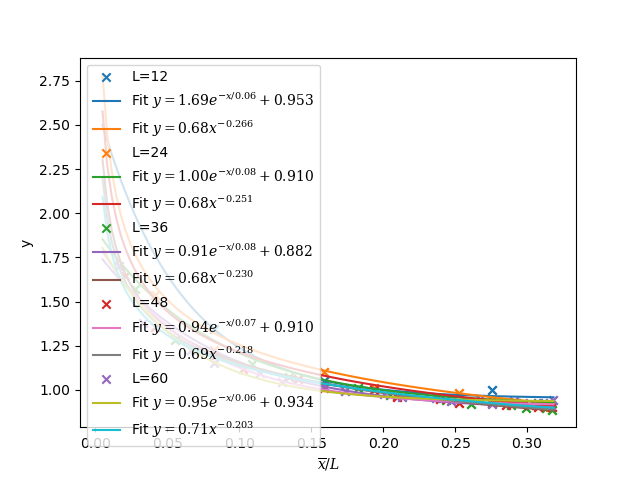

In [226]:
plt.close("all")
plt.figure()
xs = []
ys = []
cluster_count = [ 3.04646667,  3.5335899  , 5.0109202,  7.4900596, 10.88295281]

for l, d, cc in zip(L, data, cluster_count):
    x = np.arange(l)
    scaledx = np.sin(np.pi * x/l) / (np.pi/l)
    scaledx = scaledx/l

    d = d * l**2/cc

    plt.scatter(scaledx[x%3!=0], d[x%3!=0, 0], marker="x", label="L="+str(l))
    for i in range(d.shape[0]//2):
        if i % 3 == 0: continue
        xs.append(scaledx[i])
        ys.append(d[i, 0])

x = np.linspace(0.005, 1/np.pi, 100)

def fun(x, A, B, C):
    return B * np.exp(np.abs(x) / A) + C
param, _ = scipy.optimize.curve_fit(fun, xs[:20], ys[:20], p0=[-0.25, 1, 1/16], bounds=([-5, 0, 0], [-0.01, np.inf, 100]))
plt.plot(x, fun(x, *param), label=f"Fit $y={param[1]:.2f}e^{{-x/{-param[0]:.2f}}}+{param[2]:.3f}$")

def fun(x, A, B):
    return B * np.power(np.abs(x), A)
param, _ = scipy.optimize.curve_fit(fun, xs[:20], ys[:20], p0=[-0.25, 1], bounds=([-5, 0], [-0.01, np.inf]))
plt.plot(x, fun(x, *param), label=f"Fit $y={param[1]:.2f}x^{{{param[0]:.3f}}}$")

plt.legend()
plt.ylabel("y")
plt.xlabel("$\\overline{x}/L$")

In [219]:
L, data = get_all_data("new-data/finite-t/t0.1j0/*_r-3*/cluster-count.dat", lambda data, props: data[0][0], skip=1000, by="l")
print(data)

[ 3.04646667  3.5335899   5.0109202   7.4900596  10.88295281]


## CFT scaling hypothesis

0.0011473202274509802
0.0011539868941176472
0.0011466470627450982
0.0012395313803921565
0.0017724885490196076
0.00308438662745098
0.005508529206349205
0.009018878174603173
0.013558350602409642
0.01918893827309237
0.02584867317073171
0.03332455267489711


Text(0.5, 1.0, 'mono-mono L=72')

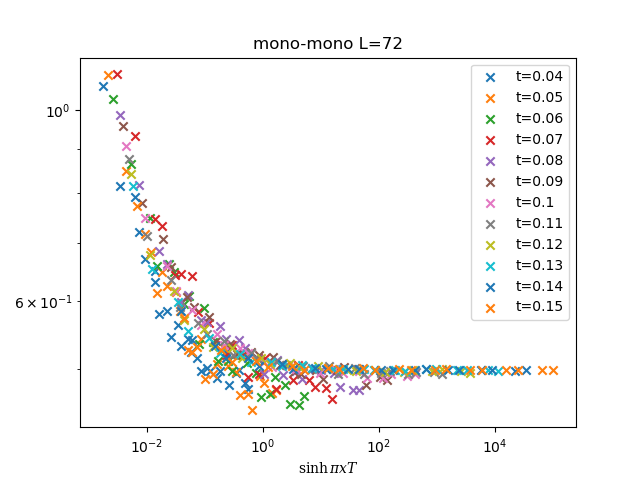

In [81]:
T, data = get_all_data("new-data/finite-t/j0/72*/mono-mono.dat", lambda data, props: data[0].reshape((props["l"], props["l"])), skip=100, by="t")
T, counts = get_all_data("new-data/finite-t/j0/72*/cluster-count.dat", lambda data, props: data[0][0], skip=100, by="t")

plt.figure()
xs = []
ys = []
for t, d, c in zip(T, data, counts):
    l = d.shape[0]
    x = np.arange(l)
    # scaledx = np.sin(np.pi * x/l) / (np.pi/l)
    scaledx = np.sinh(np.pi * x * t)
    scaledx = scaledx/l

    # c = d[32:39:3, 0].mean() + d[31:39:3, 0].mean()
    c = d[20:28:3, 0].mean() + d[19:28:3, 0].mean()
    print(c)
    d = d / c

    plt.scatter(scaledx[(x%3!=0)*(x<l//2)], d[(x%3!=0)*(x<l//2), 0], marker="x", label="t="+str(t))
    # plt.scatter(scaledx, d[:, 0], marker="x", label="t="+str(t))
    for i in range(d.shape[0]//2):
        if i % 3 == 0: continue
        xs.append(scaledx[i])
        ys.append(d[i, 0])

x = np.linspace(0.005, 1/np.pi, 100)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$\sinh \pi x T $")
plt.legend()
plt.title("mono-mono L=72")

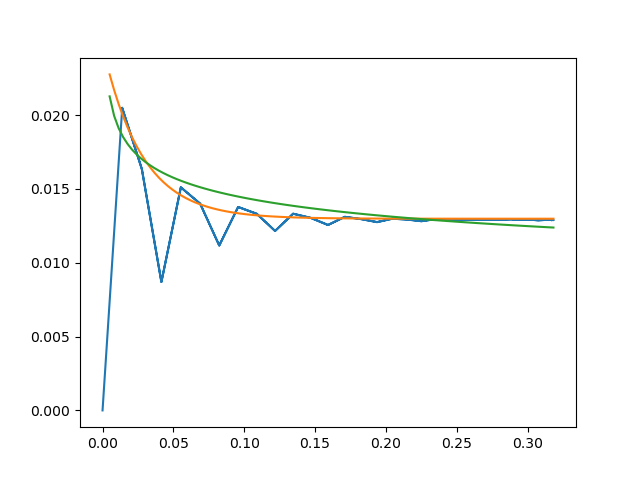

In [88]:
plt.figure()
xs = np.sin(np.pi * np.arange(72)/72) / (np.pi/72) / 72
ys = data[10][:, 0]
plt.plot(xs, ys)

s = np.arange(72)%3!=0

def fun(x, A, B, C):
    return B * np.exp(np.abs(x) / A) + C
param, _ = scipy.optimize.curve_fit(fun, xs[s], ys[s], p0=[-0.25, 1, 1/16], bounds=([-5, 0, 0], [-0.01, np.inf, 100]))
plt.plot(x, fun(x, *param), label=f"Fit $y={param[1]:.2f}e^{{-x/{-param[0]:.2f}}}+{param[2]:.3f}$")

def fun(x, A, B):
    return B * np.power(np.abs(x), A)
param, _ = scipy.optimize.curve_fit(fun, xs[s], ys[s], p0=[-0.25, 1])
plt.plot(x, fun(x, *param), label=f"Fit $y={param[1]:.2f}e^{{-x/{-param[0]:.2f}}}$")